In [1]:
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import pickle

# Paths
IMAGE_FOLDER = "Images"
OUTPUT_FEATURES_FILE = "image_features.pkl"

# Load pretrained InceptionV3 model
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

def extract_features(directory):
    features = {}
    for fname in tqdm(os.listdir(directory)):
        if not fname.lower().endswith(".jpg"):
            continue
        path = os.path.join(directory, fname)
        try:
            img = image.load_img(path, target_size=(299, 299))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            feature = model.predict(x, verbose=0)
            features[fname] = feature.flatten()
        except Exception as e:
            print(f"Error with {fname}: {e}")
    return features

if __name__ == "__main__":
    features = extract_features(IMAGE_FOLDER)
    with open(OUTPUT_FEATURES_FILE, 'wb') as f:
        pickle.dump(features, f)
    print(f"Saved extracted features to {OUTPUT_FEATURES_FILE}")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


100%|██████████| 89/89 [00:57<00:00,  1.55it/s]

Saved extracted features to image_features.pkl


In [3]:
import os
import pandas as pd
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load image features
with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

# Load and preprocess captions
def load_and_preprocess_captions(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        fname, caption = line.split(",", 1)
        caption = re.sub(r'[^a-zA-Z0-9\s]', '', caption.lower().strip())
        caption = f"<start> {caption} <end>"
        data.append((fname, caption))

    df = pd.DataFrame(data, columns=["filename", "caption"])
    return df

# Load captions
df = load_and_preprocess_captions("image_captions.txt")

# Tokenize captions
all_captions = df["caption"].tolist()
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(all_captions)
max_length = max(len(seq) for seq in sequences)

# Save max_length for later
with open("max_length.txt", "w") as f:
    f.write(str(max_length))

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Caption Length: {max_length}")


Vocabulary Size: 348
Max Caption Length: 22


In [4]:
import pickle
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Load tokenizer and max_length
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("max_length.txt", "r") as f:
    max_length = int(f.read())

# Load image features
with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

vocab_size = len(tokenizer.word_index) + 1

# Prepare training data
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Merge image + captions
X1_all, X2_all, y_all = [], [], []
for i, row in df.iterrows():
    filename = row['filename']
    if filename in image_features:
        photo = image_features[filename]
        X1, X2, y = create_sequences(tokenizer, max_length, [row['caption']], photo)
        X1_all.extend(X1)
        X2_all.extend(X2)
        y_all.extend(y)

X1_all = np.array(X1_all)
X2_all = np.array(X2_all)
y_all = np.array(y_all)

# Define the model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam())

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 256)   │     89,088 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 22, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 22)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 348)       │     89,436 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,294,172 (4.94 MB)

 Trainable params: 1,294,172 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model during training
checkpoint = ModelCheckpoint("model_caption_gen.h5", monitor='loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    [X1_all, X2_all], y_all,
    epochs=20,           # you can increase to 50–100 for more data
    batch_size=64,
    callbacks=[checkpoint]
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 5.4212
Epoch 1: loss improved from inf to 5.26049, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 238ms/step - loss: 5.4123
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 4.8125
Epoch 2: loss improved from 5.26049 to 4.77581, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 4.8105
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 4.5568
Epoch 3: loss improved from 4.77581 to 4.57415, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 4.5577
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 4.3631
Epoch 4: loss improved from 4.57415 to 4.41529, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 4.3660
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 4.1773
Epoch 5: loss improved from 4.41529 to 4.21513, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 4.1794
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 3.9832
Epoch 6: loss improved from 4.21513 to 3.95693, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 3.9817
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 3.7231
Epoch 7: loss improved from 3.95693 to 3.66562, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 3.7199
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 3.3826
Epoch 8: loss improved from 3.66562 to 3.36023, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.3813
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 3.0370
Epoch 9: loss improved from 3.36023 to 2.99100, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 3.0344
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 2.6443
Epoch 10: loss improved from 2.99100 to 2.67630, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 2.6460
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.3595
Epoch 11: loss improved from 2.67630 to 2.36795, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 2.3599
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 1.9878
Epoch 12: loss improved from 2.36795 to 2.04475, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 1.9909
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 1.8110
Epoch 13: loss improved from 2.04475 to 1.86215, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 1.8138
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1.4765
Epoch 14: loss improved from 1.86215 to 1.58206, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 1.4823
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1.3206
Epoch 15: loss improved from 1.58206 to 1.40705, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 1.3254
Epoch 16/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.2179
Epoch 16: loss improved from 1.40705 to 1.27002, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 1.2208
Epoch 17/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.0510
Epoch 17: loss improved from 1.27002 to 1.13327, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 1.0555
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.9044
Epoch 18: loss improved from 1.13327 to 0.95693, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.9073
Epoch 19/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.8077
Epoch 19: loss improved from 0.95693 to 0.86347, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 0.8108
Epoch 20/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6607
Epoch 20: loss improved from 0.86347 to 0.71957, saving model to model_caption_gen.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.6640


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Rebuild model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Load saved weights only
model.load_weights("model_caption_gen.h5")


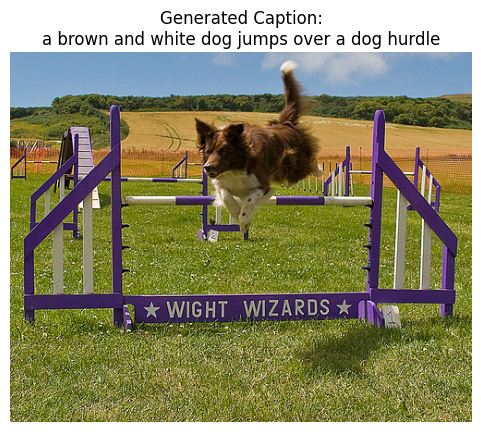

In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Rebuild InceptionV3 model to extract features from new image
from tensorflow.keras.applications.inception_v3 import InceptionV3
cnn_model = InceptionV3(weights='imagenet')
cnn_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('avg_pool').output)

# Extract features from image
def extract_feature(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = cnn_model.predict(x, verbose=0)
    return feature

# Generate caption
def generate_caption(photo, tokenizer, max_length):
    in_text = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None or word == 'end':
            break
        in_text += ' ' + word
    return in_text.replace('<start>', '').strip()

# Test image (change this path to any image you like)
test_image_path = "Images/3713133789_f05e8daffd.jpg"
photo = extract_feature(test_image_path)
caption = generate_caption(photo, tokenizer, max_length)

# Display image and caption
img = image.load_img(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Generated Caption:\n" + caption)
plt.show()
